In [1]:
import graphlab

In [2]:
loans = graphlab.SFrame('lending-club-data.gl/')

This non-commercial license of GraphLab Create for academic use is assigned to pukaracharya2052@gmail.com and will expire on July 25, 2018.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1505238185.log


In [3]:
loans.column_names()

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'is_inc_v',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'not_compliant',
 'status',
 'inactive_loans',
 'bad_loans',
 'emp_length_num',
 'grade_num',
 'sub_grade_num',
 'delinq_2yrs_zero',
 'pub_rec

In [4]:
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
loans = loans.remove_column('bad_loans')

In [5]:
target = 'safe_loans'

In [6]:
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies 
            'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]

In [7]:
loans, loans_with_na = loans[[target] + features].dropna_split()

num_rows_with_na = loans_with_na.num_rows()
num_rows = loans.num_rows()

print 'Dropping %s observations; keeping %s ' % (num_rows_with_na, num_rows)

Dropping 29 observations; keeping 122578 


In [8]:
safe_loans_raw = loans[loans[target] == 1]
risky_loans_raw = loans[loans[target] == -1]

In [9]:
percentage = len(risky_loans_raw)/float(len(safe_loans_raw))
safe_loans = safe_loans_raw.sample(percentage, seed = 1)
risky_loans = risky_loans_raw
loans_data = risky_loans.append(safe_loans)

In [10]:
print "Percentage of safe loans                 :", len(safe_loans) / float(len(loans_data))
print "Percentage of risky loans                :", len(risky_loans) / float(len(loans_data))
print "Total number of loans in our new dataset :", len(loans_data)

Percentage of safe loans                 : 0.502247166849
Percentage of risky loans                : 0.497752833151
Total number of loans in our new dataset : 46503


In [11]:
train_data, validation_data = loans_data.random_split(.8, seed=1)

In [12]:
model_5 = graphlab.boosted_trees_classifier.create(train_data, validation_set=None, 
        target = target, features = features, max_iterations = 5)

Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 37219

Number of classes           : 2

Number of feature columns   : 24

Number of unpacked features : 24

+-----------+--------------+-------------------+-------------------+

| Iteration | Elapsed Time | Training-accuracy | Training-log_loss |

+-----------+--------------+-------------------+-------------------+

| 1         | 0.046861     | 0.657541          | 0.657139          |

| 2         | 0.093223     | 0.656976          | 0.636157          |

| 3         | 0.135682     | 0.664983          | 0.623206          |

| 4         | 0.172768     | 0.668476          | 0.613783          |

| 5         | 0.214600     | 0.673339          | 0.606229          |

+-----------+--------------+-------------------+-------------------+

In [13]:
# Select all positive and negative examples.
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

# Select 2 examples from the validation set for positive & negative loans
sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

# Append the 4 examples into a single dataset
sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

Columns:
	safe_loans	int
	grade	str
	sub_grade_num	float
	short_emp	int
	emp_length_num	int
	home_ownership	str
	dti	float
	purpose	str
	payment_inc_ratio	float
	delinq_2yrs	int
	delinq_2yrs_zero	int
	inq_last_6mths	int
	last_delinq_none	int
	last_major_derog_none	int
	open_acc	int
	pub_rec	int
	pub_rec_zero	int
	revol_util	float
	total_rec_late_fee	float
	int_rate	float
	total_rec_int	float
	annual_inc	int
	funded_amnt	int
	funded_amnt_inv	int
	installment	float

Rows: 4

Data:
+------------+-------+---------------+-----------+----------------+----------------+
| safe_loans | grade | sub_grade_num | short_emp | emp_length_num | home_ownership |
+------------+-------+---------------+-----------+----------------+----------------+
|     1      |   B   |      0.2      |     0     |       3        |    MORTGAGE    |
|     1      |   B   |      0.6      |     1     |       1        |      RENT      |
|     -1     |   D   |      0.4      |     0     |       3        |      RENT      |
|     -1     |   A   |      1.0      |     0     |       11       |    MORTGAGE    |
+------------+-------+---------------+-----------+----------------+----------------+
+-------+--------------------+-------------------+-------------+------------------+
|  dti  |      purpose       | payment_inc_ratio | delinq_2yrs | delinq_2yrs_zero |
+-------+--------------------+-------------------+-------------+------------------+
| 29.44 |    credit_card     |      6.30496      |      0      |        1         |
| 12.19 |    credit_card     |      13.4952      |      0      |        1         |
| 13.97 |       other        |      2.96736      |      3      |        0         |
| 16.33 | debt_consolidation |      1.90524      |      0      |        1         |
+-------+--------------------+-------------------+-------------+------------------+
+----------------+------------------+-----------------------+----------+---------+
| inq_last_6mths | last_delinq_none | last_major_derog_none | open_acc | pub_rec |
+----------------+------------------+-----------------------+----------+---------+
|       0        |        1         |           1           |    8     |    0    |
|       0        |        1         |           1           |    8     |    0    |
|       0        |        0         |           1           |    14    |    0    |
|       0        |        1         |           1           |    17    |    0    |
+----------------+------------------+-----------------------+----------+---------+
+--------------+------------+--------------------+----------+-----+
| pub_rec_zero | revol_util | total_rec_late_fee | int_rate | ... |
+--------------+------------+--------------------+----------+-----+
|      1       |    93.9    |        0.0         |   9.91   | ... |
|      1       |    59.1    |        0.0         |  11.71   | ... |
|      1       |    59.5    |        0.0         |  16.77   | ... |
|      1       |    62.1    |        0.0         |   8.9    | ... |
+--------------+------------+--------------------+----------+-----+
[4 rows x 25 columns]

In [14]:
model_5.predict(sample_validation_data)

dtype: int
Rows: 4
[1, 1, -1, 1]

In [15]:
# Quiz

In [16]:
len(sample_validation_data[sample_validation_data['safe_loans'] == model_5.predict(sample_validation_data)])/float(len(sample_validation_data))

0.75

In [17]:
# Quiz

In [18]:
model_5.predict(sample_validation_data, output_type='probability')

dtype: float
Rows: 4
[0.7045905590057373, 0.5963408946990967, 0.44925159215927124, 0.6119099855422974]

In [19]:
model_5.evaluate(validation_data)

{'accuracy': 0.66813873330461,
 'auc': 0.7247215702188436,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      -1      |        1        |  1618 |
 |      1       |        -1       |  1463 |
 |      -1      |        -1       |  3054 |
 |      1       |        1        |  3149 |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.6715001599317625,
 'log_loss': 0.6176131769648966,
 'precision': 0.6605831760016782,
 'recall': 0.6827840416305291,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 100001
 
 Data:
 +-----------+-----+-----+------+------+
 | threshold | fpr | tpr |  p   |  n   |
 +-----------+-----+-----+------+------+
 |    0.0    | 1.0 | 1.0 | 4612 | 4672 |
 |   1e-05   | 1.0 | 1.0 | 4612 | 4672 |
 |   2e-05   | 1.0 | 

In [20]:
graphlab.canvas.set_target('ipynb')
model_5.show(view='Evaluation')

In [23]:
predictions = model_5.predict(validation_data)

In [24]:
len(predictions)

9284

In [25]:
confusion_matrix = model_5.evaluate(validation_data)['confusion_matrix']
confusion_matrix

target_label,predicted_label,count
-1,1,1618
1,-1,1463
-1,-1,3054
1,1,3149


In [26]:
# Quiz ^ 

In [28]:
confusion_matrix[(confusion_matrix['target_label'] == -1) & (confusion_matrix['predicted_label'] == 1)]

target_label,predicted_label,count
-1,1,1618


In [29]:
false_positives = confusion_matrix[(confusion_matrix['target_label'] == -1) & (confusion_matrix['predicted_label'] == 1)]['count'][0]
print false_positives

1618


In [30]:
false_negatives = confusion_matrix[(confusion_matrix['target_label'] == 1) & (confusion_matrix['predicted_label'] == -1)]['count'][0]
print false_negatives

1463


In [31]:
# Quiz

In [32]:
cost_of_mistakes = (false_negatives * 10000) + (false_positives * 20000)
print cost_of_mistakes

46990000


In [33]:
validation_data['predictions'] = model_5.predict(validation_data, output_type='probability')

In [34]:
print "Your loans      : %s\n" % validation_data['predictions'].head(4)
print "Expected answer : %s" % [0.4492515948736132, 0.6119100103640573,
                                0.3835981314851436, 0.3693306705994325]

Your loans      : [0.44925159215927124, 0.6119099855422974, 0.38359811902046204, 0.3693307042121887]

Expected answer : [0.4492515948736132, 0.6119100103640573, 0.3835981314851436, 0.3693306705994325]


In [35]:
validation_data[['grade','predictions']].sort('predictions', ascending = False)[0:5]

grade,predictions
A,0.848508358002
A,0.848508358002
A,0.841295421124
A,0.841295421124
A,0.841295421124


In [36]:
# Quiz ^

In [37]:
# Quiz

In [38]:
validation_data[['grade','predictions']].sort('predictions', ascending = True)[0:5]

grade,predictions
D,0.134275108576
C,0.134275108576
C,0.134275108576
C,0.134275108576
B,0.134275108576


In [39]:
model_10 = graphlab.boosted_trees_classifier.create(train_data, validation_set=None, 
        target = target, features = features, max_iterations = 10, verbose=False)

In [40]:
model_50 = graphlab.boosted_trees_classifier.create(train_data, validation_set=None, 
        target = target, features = features, max_iterations = 50, verbose=False)
model_100 = graphlab.boosted_trees_classifier.create(train_data, validation_set=None, 
        target = target, features = features, max_iterations = 100, verbose=False)
model_200 = graphlab.boosted_trees_classifier.create(train_data, validation_set=None, 
        target = target, features = features, max_iterations = 200, verbose=False)
model_500 = graphlab.boosted_trees_classifier.create(train_data, validation_set=None, 
        target = target, features = features, max_iterations = 500, verbose=False)

In [41]:
# Quiz

In [42]:
print model_10.evaluate(validation_data)['accuracy']
print model_50.evaluate(validation_data)['accuracy']
print model_100.evaluate(validation_data)['accuracy']
print model_200.evaluate(validation_data)['accuracy']
print model_500.evaluate(validation_data)['accuracy']

0.672770357604
0.690758293839
0.691727703576
0.684510986644
0.671800947867


In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
def make_figure(dim, title, xlabel, ylabel, legend):
    plt.rcParams['figure.figsize'] = dim
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend is not None:
        plt.legend(loc=legend, prop={'size':15})
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

In [45]:
train_err_10 = 1 - model_10.evaluate(train_data)['accuracy']
train_err_50 = 1 - model_50.evaluate(train_data)['accuracy']
train_err_100 = 1 - model_100.evaluate(train_data)['accuracy']
train_err_200 = 1 - model_200.evaluate(train_data)['accuracy']
train_err_500 = 1 - model_500.evaluate(train_data)['accuracy']

In [46]:
training_errors = [train_err_10, train_err_50, train_err_100, 
                   train_err_200, train_err_500]

In [47]:
validation_err_10 = 1 - model_10.evaluate(validation_data)['accuracy']
validation_err_50 = 1 - model_50.evaluate(validation_data)['accuracy']
validation_err_100 = 1 - model_100.evaluate(validation_data)['accuracy']
validation_err_200 = 1 - model_200.evaluate(validation_data)['accuracy']
validation_err_500 = 1 - model_500.evaluate(validation_data)['accuracy']

In [48]:
validation_errors = [validation_err_10, validation_err_50, validation_err_100, 
                     validation_err_200, validation_err_500]

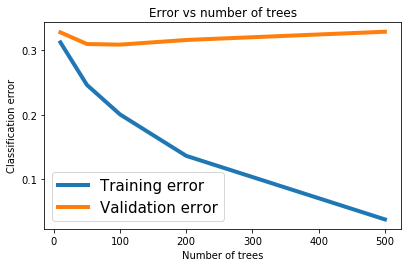

In [49]:
plt.plot([10, 50, 100, 200, 500], training_errors, linewidth=4.0, label='Training error')
plt.plot([10, 50, 100, 200, 500], validation_errors, linewidth=4.0, label='Validation error')

make_figure(dim=(10,5), title='Error vs number of trees',
            xlabel='Number of trees',
            ylabel='Classification error',
            legend='best')